In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [2]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

In [3]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,f_type,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise)
    #initialize function
    f_vals_vanilla = X_test
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    alpha = 1./4*gamma*(sig**2)*(1./(1-gamma*a) + 1.)
    beta = gamma*(a*c-1./2*sig**2)
    for i in range(lag):
        #second-order coefficients
        #bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        #bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        bar_a_2[i,1:] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(X_test[:-1]))**2)
        bar_a_2[i,0] = coefs_poly_regr[i,1]*np.sqrt(2)*alpha +\
                    coefs_poly_regr[i,2]*np.sqrt(2)*(7*alpha**2 + gamma*(sigma(x0))**2)
        #first-order coefficients
        #bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(X_test[:-1]+gamma*b(X_test[:-1]))
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*X_test[:-1] + beta)*(np.sqrt(gamma)*sigma(X_test[:-1]) + alpha) +\
                                    6*alpha*sigma(X_test[:-1])*np.sqrt(gamma))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                coefs_poly_regr[i,2]*(2*((1-gamma*a)*x0 + beta)*(np.sqrt(gamma)*sigma(x0) + alpha) +\
                                    6*alpha*sigma(x0)*np.sqrt(gamma))        
        #bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        #coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0+gamma*b(x0))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test

In [4]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    coefs_poly = np.array([])
    for i in range(lag):
        print(i)
        x_all = np.zeros((X_train.shape[0]*(X_train.shape[1]-i),X_train.shape[2]))
        y_all = np.zeros_like(x_all)
        print(x_all.shape)
        #x_all = np.array([])
        #y_all = np.array([])
        for j in range(N_traj_train):
            if i > 0:
                x_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = X_train[j,:-i]
                y_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = Y_train[j,i:]
            elif i ==0:
                x_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = X_train[j,:]
                y_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = Y_train[j,i:]
        #should use polyfeatures here
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [5]:
a = 5.0
c = 5.0
sig = 2.0

def b(X_t):
    """
    b function in the diffusion
    """
    return a*(c-X_t)

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.sqrt(X_t)

def sample_discretized_diffusion(X_t,gamma_t):
    """
    args:   X_t - current value, 
            gamma_t - step size;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn()
    return (1-gamma_t*a)*X_t + gamma_t*(a*c-1./4*(sig**2)) + np.sqrt(gamma_t*X_t)*sig*xi + 0.25*gamma_t*(sig**2)*(xi**2 + (xi**2)/(1-gamma_t*a) - 1),xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros(n,dtype = float)
    noise_all = np.zeros(n,dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [6]:
n = 2*10**5 #sample size
gamma = 2e-2 # Step size
n_traj = 100
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 200 #maximal lag order
N_test = 2*10**3

Sample discretized diffusion

In [7]:
def generate_observations(x0,n,gamma,r_seed,n_traj):
    X_train_all = np.zeros((n_traj,n,1),dtype=float)
    Noise_train_all = np.zeros_like(X_train_all)
    Y_train_all = np.zeros((n_traj,n,1),dtype=float)
    nbcores = multiprocessing.cpu_count()
    trav = Pool(nbcores)
    train_traj = trav.starmap(generate_traj, [(x0,n,gamma,r_seed+i) for i in range (n_traj)])
    trav.close()
    train_traj = np.asarray(train_traj)
    X_train_all[:,:,0] = train_traj[:,0,:]
    Noise_train_all[:,:,0] = train_traj[:,1,:]
    Y_train_all[:,:,0] = X_train_all[:,:,0]
    return X_train_all, Noise_train_all, Y_train_all

In [8]:
x0 = 1
r_seed = 1812
N_gammas = 5
X_train = np.zeros((N_gammas,n_traj,n,1),dtype=float)
Noise_train = np.zeros((N_gammas,n_traj,n,1),dtype=float)
Y_train = np.zeros((N_gammas,n_traj,n,1),dtype=float)

for i in range(N_gammas):
    X_train[i],Noise_train[i],Y_train[i] = generate_observations(x0,n,(i+1)*gamma,r_seed,n_traj)

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [9]:
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
coefs_poly = trav.starmap(approx_q, [(X_train[i],Y_train[i],n_traj,lag,S_max) for i in range (N_gammas)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
coefs_poly = np.asarray(coefs_poly)
print(coefs_poly.shape)

0
(20000000, 1)
(20000000, 3)
1
(19999900, 1)
0
(20000000, 1)
(19999900, 3)
(20000000, 3)
2
0
(20000000, 1)
(19999800, 1)
1
(19999900, 1)
(20000000, 3)
(19999800, 3)
(19999900, 3)
0
(20000000, 1)
3
(19999700, 1)
1
(19999900, 1)
0
(20000000, 1)
(20000000, 3)
2
(19999800, 1)
(19999900, 3)
(19999700, 3)
(20000000, 3)
1
(19999900, 1)
(19999800, 3)
2
(19999800, 1)
(19999900, 3)
1
4(19999900, 1)

(19999600, 1)
3
(19999700, 1)
(19999800, 3)
2
(19999800, 1)
(19999900, 3)
(19999600, 3)
(19999700, 3)
3
(19999700, 1)(19999800, 3)

5
(19999500, 1)
2
(19999800, 1)
4
3
(19999700, 3)
(19999600, 1)
(19999700, 1)(19999500, 3)

(19999800, 3)
(19999600, 3)
(19999700, 3)
4
(19999600, 1)
6
3(19999400, 1)

(19999700, 1)
5
(19999500, 1)
(19999600, 3)
4
(19999600, 1)
(19999400, 3)
(19999700, 3)
(19999500, 3)
5
(19999600, 3)
(19999500, 1)
7
(19999300, 1)
4
6
(19999600, 1)
(19999400, 1)(19999500, 3)

5
(19999500, 1)
(19999300, 3)
(19999600, 3)
(19999400, 3)
6
(19999500, 3)
(19999400, 1)
(19999400, 3)
5
8
(19999

(19994800, 3)
(19994600, 1)
(19994800, 3)
54
(19994800, 3)
(19994600, 1)
(19994600, 3)
53
(19994700, 1)
53
(19994600, 3)
(19994700, 1)
53
(19994700, 1)
55
(19994700, 3)
(19994500, 1)
(19994700, 3)
55
(19994500, 1)
(19994700, 3)
(19994500, 3)
54
(19994600, 1)
(19994500, 3)
54
(19994600, 1)
54(19994600, 3)

(19994600, 1)
56
(19994400, 1)
(19994600, 3)
56
(19994400, 1)
(19994600, 3)
55
(19994500, 1)
(19994400, 3)
(19994400, 3)
55
(19994500, 3)(19994500, 1)

55
(19994500, 1)
57
(19994300, 1)
57
(19994300, 1)
(19994500, 3)
56
(19994400, 1)
(19994300, 3)
(19994500, 3)
(19994300, 3)
(19994400, 3)
56
(19994400, 1)
58
(19994200, 1)
56
(19994400, 1)
58
(19994200, 1)
(19994400, 3)
57
(19994300, 1)
(19994200, 3)
(19994400, 3)
(19994200, 3)
57
(19994300, 3)
(19994300, 1)
59
(19994100, 1)
(19994300, 3)
59
(19994100, 1)
57
58
(19994300, 1)
(19994200, 1)
(19994100, 3)
58
(19994100, 3)
(19994200, 1)
(19994300, 3)
(19994200, 3)
(19994200, 3)
60
(19994000, 1)
60
58
59
(19994000, 1)(19994200, 1)

(1999410

(19989400, 1)
106
104
(19989400, 3)
(19989400, 1)(19989600, 1)

106
(19989400, 1)
(19989400, 3)
(19989400, 3)
(19989600, 3)
107
(19989300, 1)
(19989400, 3)
107
(19989300, 3)
(19989300, 1)
105
107(19989500, 1)

(19989300, 1)
107
(19989300, 1)
(19989300, 3)
(19989500, 3)
(19989300, 3)
108
(19989200, 1)
(19989300, 3)
108
(19989200, 1)
(19989200, 3)
108
106
(19989200, 1)
(19989400, 1)
108
(19989200, 1)
(19989200, 3)
(19989400, 3)
(19989200, 3)109

(19989100, 1)
(19989200, 3)
109
(19989100, 1)
(19989100, 3)
107
(19989300, 1)
109
(19989100, 3)
109(19989100, 1)

(19989100, 1)
110
(19989100, 3)(19989300, 3)

(19989000, 1)
(19989100, 3)
110
(19989000, 1)
(19989000, 3)
110
110
(19989000, 3)
(19989000, 1)
(19989000, 1)
108
(19989200, 1)
111
(19988900, 1)
(19989000, 3)
(19989000, 3)
(19989200, 3)111

(19988900, 1)
(19988900, 3)
(19988900, 3)
111
111
109
(19988900, 1)
(19989100, 1)
(19988900, 1)
112
(19988800, 1)
112
(19988900, 3)(19988900, 3)

(19988800, 1)
(19989100, 3)
(19988800, 3)
(19988800, 3

(19984300, 3)
155
(19984500, 1)
(19984300, 3)
(19984300, 3)
157
(19984300, 1)
158
(19984200, 1)
(19984500, 3)
(19984300, 3)
158
158
(19984200, 1)
(19984200, 1)
(19984200, 3)
156
(19984400, 1)
(19984200, 3)
158
(19984200, 1)
(19984200, 3)
159
(19984100, 1)
(19984400, 3)
(19984200, 3)
159
(19984100, 1)
159
(19984100, 1)
(19984100, 3)
157
(19984100, 3)
(19984300, 1)
159
(19984100, 1)
(19984100, 3)
160
(19984000, 1)
(19984300, 3)
(19984100, 3)
160
(19984000, 3)
(19984000, 1)160

(19984000, 1)
158
(19984200, 1)
(19984000, 3)
160
(19984000, 1)
161
(19984000, 3)
(19983900, 1)
(19984200, 3)
(19984000, 3)
161
(19983900, 1)
(19983900, 3)
161
(19983900, 1)
159
(19984100, 1)
(19983900, 3)
(19983900, 3)
161162

(19983800, 1)
(19983900, 1)
(19984100, 3)
162
162
(19983800, 1)
(19983800, 1)
(19983800, 3)
(19983900, 3)
160
(19984000, 1)
(19983800, 3)
(19983800, 3)
163
(19983700, 1)
(19984000, 3)
162
163
(19983800, 1)
(19983700, 1)
163
(19983700, 1)
(19983700, 3)
161
(19983900, 1)
(19983800, 3)
(1998370

In [10]:
#polynomial coefficients
print(coefs_poly.shape)
regr_vals = np.zeros((lag,X_train.shape[2]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[0][i,j]*X_train[0,0,:,0]**j

(5, 200, 3)


Test our regressors

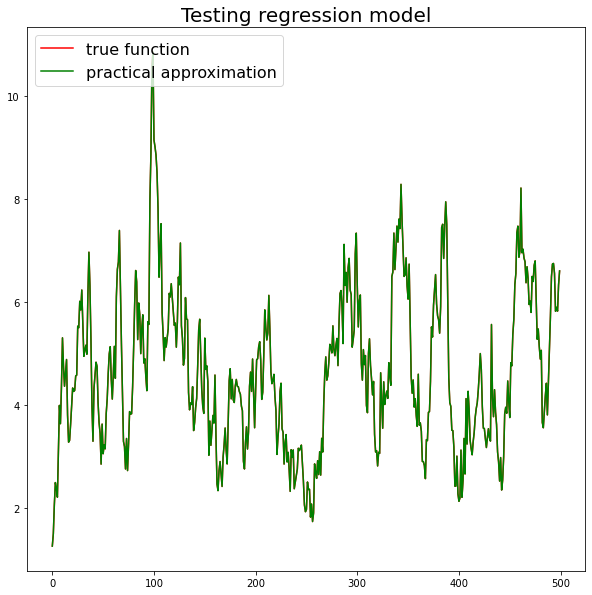

In [11]:
cur_lag = 0
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [12]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly[0],gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res = np.asarray(res)

M_n_2: M_n_2:   20.772867622924323
M_n_1:  404.9098627967086
M_n_2: -8.018510875365612M_n_2: 
  M_n_2: M_n_2:  M_n_1: 22.097447108506838-57.087673162377676M_n_2: M_n_2: M_n_2:     

-12.246224427956722M_n_2: 46.75261218652382 M_n_1: M_n_2: -4.81559767775746-12.926382211844835-10.529594629633744
M_n_2: 187.8785191967356  M_n_2: M_n_1: M_n_2: 
 

M_n_2: M_n_2: M_n_1: 
 160.97329378308868M_n_1:    M_n_1: M_n_1: -32.64126756392887 M_n_2:  M_n_1:  
-15.926035684397348187.21978356959238
-2.7616679736087493-18.58035626481638418.349417827949477  
 -9.373977943901602M_n_2:  46.684880673604226



244.31178282602167M_n_1: -2.899022612938046M_n_2: 229.15826818675643-276.6104664514329
 M_n_1: 
 
-70.69681640062025M_n_2:  M_n_2: M_n_1: 


M_n_1: M_n_1:   
-31.3727318558838
M_n_2: M_n_1: -8.911889321325358  -6.0258667112438795  M_n_2: 802.6953588704686-0.5631707199611968-92.43787527115943-430.5370600511341


 16.387322221570383
M_n_1:  -41.500174223025994

M_n_1:   -27.99828566091887136.7154292921371

In [13]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_1 = trav.starmap(test_traj, [(coefs_poly[1],2*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_1 = np.asarray(res_1)

M_n_2:  M_n_2:  -8.425220081338345-13.315626105773186
M_n_1:  M_n_2: M_n_2: 
 142.65969378161176M_n_2: M_n_1: 
M_n_2:  M_n_2: -9.981952732372221M_n_2: M_n_2: M_n_2: 17.73929384263552M_n_2:    
M_n_2:   M_n_2: M_n_2:  M_n_2:   M_n_2: M_n_2: 
21.097830729663386M_n_2: -5.366555734607658M_n_2: 14.967198106598824M_n_1: -8.98853944683996-33.4488531443836719.53812047421966    M_n_2:  -13.401491797074684M_n_1: -17.2958651504848 


 
-1.3575552851837855 M_n_2: M_n_2: 
50.50775536141391
26.621264568853704M_n_2: 
-3.2927694940911105 
22.871525926723947 8.146300409208033M_n_2: M_n_1:  M_n_1: 199.03336065460243
-60.626595325485944

M_n_1: M_n_1: -3.6547765972476265M_n_1: 
 -31.168611028646193-22.167525248593254  
M_n_1: M_n_1: 
 M_n_1:   M_n_1: 

 

 -34.76408250799353152.59880948080763M_n_1:  
M_n_1:  M_n_1:   M_n_1: 23.549314234405642M_n_1: -19.94699195832327M_n_1:  83.01215326720107
556.6425642055751
-5.529788493647936-294.8898080883791 M_n_1: -69.07253068248245   -203.2687403725881 -20.10151201

In [14]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_2 = trav.starmap(test_traj, [(coefs_poly[2],3*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_2 = np.asarray(res_2)

M_n_2:  M_n_2: 28.722047552895603 
M_n_2: 16.145348109253696M_n_1: M_n_2: M_n_2:   
M_n_2:   -34.231431950147574M_n_2: 81.99028077706103 
M_n_1: 
 25.02952611010001M_n_2: M_n_2: M_n_1: 19.23538046083781M_n_2: -13.815604085102757
-4.392071009870955M_n_2:  M_n_2: 

In [15]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_3 = trav.starmap(test_traj, [(coefs_poly[3],4*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_3 = np.asarray(res_3)

In [16]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_4 = trav.starmap(test_traj, [(coefs_poly[4],5*gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_4 = np.asarray(res_4)

### Comparison plots

In [17]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    #ax.set_ylim(-0.12, 0.12)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [18]:
title = ""
labels = ['Vanilla, \n $\\gamma = 0.01$', 'Vanilla, \n $\\gamma = 0.02$',\
          'Vanilla, \n $\\gamma = 0.03$', 'Vanilla, \n $\\gamma = 0.04$', 'Vanilla, \n $\\gamma = 0.05$']

In [19]:
data = [res[:,0]-np.mean(res[:,0]),res_1[:,0]-np.mean(res_1[:,0]),res_2[:,0]-np.mean(res_2[:,0]),\
        res_3[:,0] - np.mean(res_3[:,0]),res_4[:,0] - np.mean(res_4[:,0])]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./CIR_vanilla_gamma_influence.pdf")

In [20]:
title = ""
labels = ['MDCV-2, \n $\\gamma = 0.01$', 'MDCV-2, \n $\\gamma = 0.02$',\
          'MDCV-2, \n $\\gamma = 0.03$', 'MDCV-2, \n $\\gamma = 0.04$', 'MDCV-2, \n $\\gamma = 0.05$']

In [21]:
data = [res[:,2]-np.mean(res[:,2]),res_1[:,2]-np.mean(res_1[:,2]),res_2[:,2]-np.mean(res_2[:,2]),\
        res_3[:,2] - np.mean(res_3[:,2]),res_4[:,2] - np.mean(res_4[:,2])]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./CIR_2nd_order_gamma_influence_upd.pdf")